In [841]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter
from itertools import chain
%matplotlib inline
# np.random.seed(46)

In [842]:
#Option de la simulation
TYPE_TIRAGE = "loto" # ou "euromillion"
NB_ANNEES = 10  # Nombre d'années de simulation
NB_TIRAGE_PAR_SEMAINE  = 3 # Nombre de tirage par semaine
PRIX_LOTO = 2.20 # Prix d'une grille de loto
NB_TIRAGE_LOTO_SEMAINE = 3 # Nombre de tirage de loto par semaine
BASSE_FREQUENCE = False # Si True, les numéros et étoiles sont tirés selon leur fréquence d'apparition a la place du joueur

#euromillion # Nombre de tirage d'euromillion par semaine
PRIX_EUROMILLION = 2.30 # Prix d'une grille d'euromillion
 
#Grille du joueur si basse_frequence = False
GRILLE_NUMERO = [2,9,24,33,43] # 5 numéros
GRILLE_ETOILE = [5] # 1 étoiles





In [843]:
#cerveaux simulateur
#set joueur : 
grille_joueur = {"numero" :set(GRILLE_NUMERO) ,
          "etoile" : set(GRILLE_ETOILE)}

if_gain_loto = {
    "0,0":0,
    "1,0":0,
    "1,1": 2.20,
    "0,1": 2.20,
    "2,0": 4.50,
    "2,1": 11.10,
    "3,0": 18.60,
    "3,1": 50,
    "4,0": 335,
    "4,1": 817,
    "5,0": 68000,
    "5,1": 1000000
}
if_gain_euro_million = {
    "0,0":0,
    "1,0":0,
    "1,1":2.30,
    "0,1": 2.30,
    "2,0": 4.50,
    "2,1": 6.20,
    "3,0": 11.20,
    "3,1": 13.40,
    "2,2": 14.10,
    "4,0": 49.80,
    "3,2": 65.60,
    "4,1": 152.2,
    "4,2": 1773.40,
    "5,0": 23809,
    "5,1": 560301,
    "5,2": 10000000
}

def tirage_loto(numero_tirer=5,etoile_tirer=1) ->dict[str : tuple]:
    numero = np.arange(1,50)
    etoile = np.arange(1,10)
    numero = np.random.choice(numero,5,False)
    etoile = np.random.choice(etoile,1,False)    
    tirage = {"numero" : set(numero),
              "etoile" : set(etoile)}
    return tirage

def get_lower_frequence_number(data_frequence_sortie_numero:pd.DataFrame, data_frequence_sortie_etoile):
    # recupere les 5 numero et 1 etoile les moins sorties
    numero_sortie_moin_souvent = list(data_frequence_sortie_numero.nsmallest(5,"frequence")["frequence"].index)
    etoile_sortie_moin_souvent = list(data_frequence_sortie_etoile.nsmallest(1,"frequence")["frequence"].index)
    grille_a_joueur = {"numero" : set(numero_sortie_moin_souvent),
                       "etoile" : set(etoile_sortie_moin_souvent)}
    return grille_a_joueur


def Calcule_gain_loto(numero_joueur,tirage) -> float:
    nb_numero_gagniant = len(numero_joueur["numero"].intersection((tirage["numero"])))
    nb_etoile_gagniant = len(numero_joueur["etoile"].intersection((tirage["etoile"])))
    select_gain = str(f"{nb_numero_gagniant},{nb_etoile_gagniant}")
    return if_gain_loto[select_gain] - PRIX_LOTO

def Calcule_gain_euromillion(numero_joueur,tirage) -> float:
    nb_numero_gagniant = len(numero_joueur["numero"].intersection((tirage["numero"])))  
    nb_etoile_gagniant = len(numero_joueur["etoile"].intersection((tirage["etoile"])))
    select_gain = str(f"{nb_numero_gagniant},{nb_etoile_gagniant}")
    return if_gain_euro_million[select_gain]


def counter_to_pandas(dict_counter : Counter) -> pd.DataFrame:
    return pd.DataFrame.from_dict(dict_counter,"index",columns=["frequence"])

def tirages_loto(numero_joueur,limit_annee = 30,nombre_tirage_semaine=3,n_joueur_basse_frequence=False)-> tuple[pd.DataFrame,pd.DataFrame,pd.DataFrame]:
    data = []
    gain_cumuler = 0
    depense_cumuler = 0
    partie_jouer = 0
    annee = 0
    gain_semaine = 0
    jackpot = 0
    dict_frequence_etoile = Counter(np.arange(1,50))
    dict_frequence_numero = Counter(np.arange(1,50))
    win = True
    while win and annee < limit_annee:
        # print(gain_ans)
        annee += 1
        for semaine in range(0,52):
            gain_semaine +=1
            for jour in range(0,3):
                depense_cumuler += PRIX_LOTO
                partie_jouer +=1
                tirage_n_gagniant = tirage_loto()
                dict_frequence_numero.update(Counter(tirage_n_gagniant["numero"]))
                dict_frequence_etoile.update(Counter(tirage_n_gagniant["etoile"]))
                if n_joueur_basse_frequence:
                    numero_joueur = get_lower_frequence_number(counter_to_pandas(dict_frequence_numero),counter_to_pandas(dict_frequence_etoile))
                    jackpot =  Calcule_gain_loto(numero_joueur,tirage_n_gagniant)
                else:
                    jackpot =  Calcule_gain_loto(numero_joueur,tirage_n_gagniant)
                gain_cumuler += jackpot
                data.append({
                    "Gain": jackpot,
                    "Gain_cumuler" : round(gain_cumuler,2),
                    "Depense_cumuler": round(depense_cumuler,2),
                    "Annee": annee,
                    "Semaine": gain_semaine,
                    "Numeros_joueur" : numero_joueur["numero"],
                    "Etoile_joueur" : numero_joueur["etoile"],
                    "Numero_gagnant": tirage_n_gagniant["numero"],
                    "Etoile_gagnante": tirage_n_gagniant["etoile"],
                    "Win" : jackpot>=0
                })
                
                if jackpot >= 100000:
                    print(jackpot)
                    win = False
    print("gain : ",gain_cumuler)
    print("depense : ",depense_cumuler)
    print("annee : ",annee)
    print("semaine : ",gain_semaine)
    print("partie jouer : ",partie_jouer)
    historique_tirage = pd.DataFrame(data).set_index("Annee")
    count_numero_sortie = Counter(chain.from_iterable(historique_tirage.reset_index()["Numero_gagnant"].values))
    count_etoile_sortie = Counter(chain.from_iterable(historique_tirage.reset_index()["Etoile_gagnante"].values))
    numero_gagniant_repartition = pd.DataFrame.from_dict(count_numero_sortie,"index",columns=["frequence"])
    etoile_gagniant_repartition = pd.DataFrame.from_dict(count_etoile_sortie,"index",columns=["frequence"])




    return  historique_tirage,numero_gagniant_repartition, etoile_gagniant_repartition

In [844]:
# Simulation
data_loto,repartition_numero, repartition_etoile =  tirages_loto(grille_joueur,NB_ANNEES,NB_TIRAGE_PAR_SEMAINE,BASSE_FREQUENCE)
display(data_loto["Win"].value_counts().rename({True:"Gagnant",False:"Perdant"}))

gain :  -2204.000000000024
depense :  3431.9999999999154
annee :  10
semaine :  520
partie jouer :  1560


Win
Perdant    1267
Gagnant     293
Name: count, dtype: int64

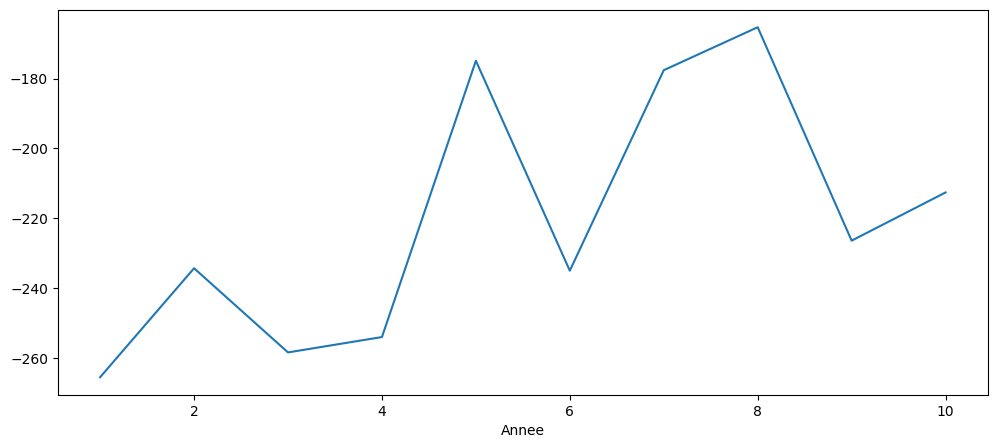

In [845]:
#Repartition des gain sur les années
data_loto.groupby("Annee")["Gain"].sum().plot(figsize=[12,5]);

In [846]:
#top 10 des plus gros gros gains
data_loto.nlargest(20,"Gain").nlargest(50,"Gain")

,Gain,Gain_cumuler,Depense_cumuler,Semaine,Numeros_joueur,Etoile_joueur,Numero_gagnant,Etoile_gagnante,Win
Annee,,,,,,,,,
5,47.8,-1071.4,1531.2,232,"{33, 2, 9, 43, 24}",{5},"{33, 43, 19, 24, 31}",{5},True
8,47.8,-1627.2,2554.2,387,"{33, 2, 9, 43, 24}",{5},"{2, 9, 10, 43, 42}",{5},True
6,16.4,-1278.1,1845.8,280,"{33, 2, 9, 43, 24}",{5},"{33, 40, 9, 43, 26}",{8},True
7,16.4,-1540.8,2305.6,350,"{33, 2, 9, 43, 24}",{5},"{2, 39, 9, 15, 24}",{7},True
8,16.4,-1655.3,2525.6,383,"{33, 2, 9, 43, 24}",{5},"{32, 2, 9, 24, 25}",{9},True
9,16.4,-1989.2,3086.6,468,"{33, 2, 9, 43, 24}",{5},"{33, 5, 43, 24, 25}",{4},True
10,16.4,-2141.5,3317.6,503,"{33, 2, 9, 43, 24}",{5},"{33, 9, 46, 24, 27}",{1},True
10,16.4,-2186.4,3412.2,517,"{33, 2, 9, 43, 24}",{5},"{33, 2, 9, 13, 27}",{1},True
7,8.9,-1456.9,2127.4,323,"{33, 2, 9, 43, 24}",{5},"{8, 9, 12, 22, 24}",{5},True


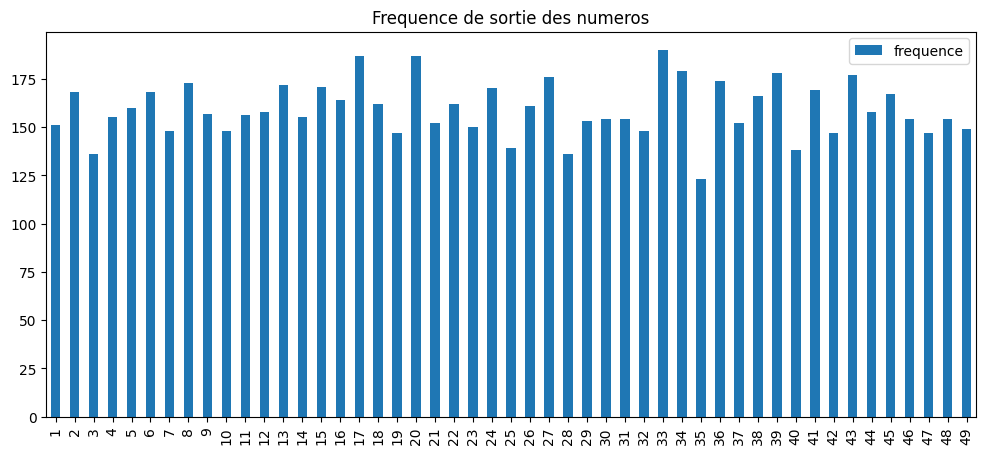

In [847]:
#frequence de sortie des numeros
repartition_numero.sort_index().plot(kind="bar",figsize=[12,5])
plt.title("Frequence de sortie des numeros");


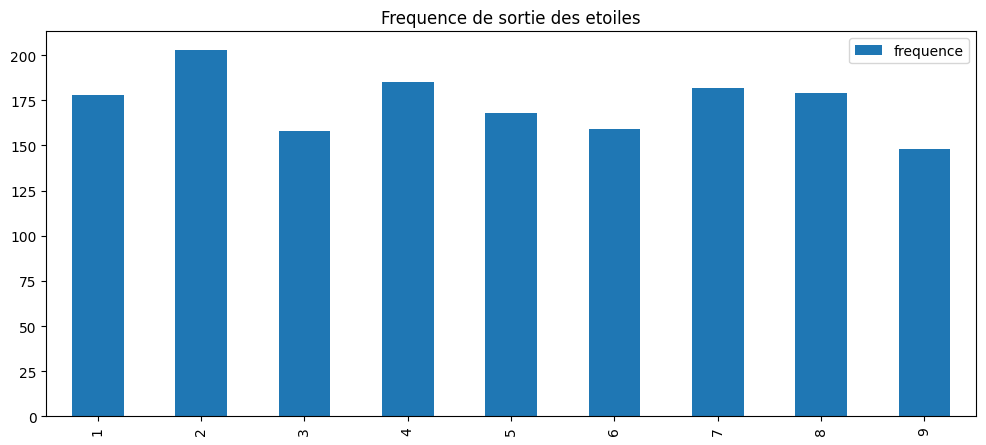

In [848]:
#frequence de sortie des etoiles
repartition_etoile.sort_index().plot(kind="bar",figsize=[12,5])
plt.title("Frequence de sortie des etoiles");